In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numbers

from scipy.integrate import odeint, ode
from copy import deepcopy

red  = sns.xkcd_rgb["pale red"]
blue = sns.xkcd_rgb["denim blue"]
gray = "#505050"

sns.set(rc = {'figure.figsize': (3, 2), 'font.family': 'sans-serif', 'font.sans-serif': "Arial"})

In [2]:
class Parms:
    _parms_str = []
    _def_parms = []
    _parms_idx = {}
    
    def __init__(self, **kwargs):
        self._parms_dict = dict(zip(self._parms_str, self._def_parms))
        for key in kwargs:
            self[key] = kwargs[key]
    
    def __str__(self):
        return "Parameter values: \n" + "\n".join(["%s = %g" % (key, self._parms_dict[key]) for key in self._parms_str])
        
    def __len__ (self):
        return len(self._parms_str)
    
    @classmethod
    def __check_parm(cls, key, value = None):
        if not key in cls._parms_str:
            sys.exit("Unknown parameter: %s" % key)
        if value and (not isinstance(value, numbers.Number)):
            sys.exit('"%s" is not a number.' % value)        
    
    def __getitem__ (self, key):
        self.__check_parm(key)
        return self._parms_dict[key]
    
    def __setitem__ (self, key, value):
        self.__check_parm(key, value)
        self._parms_dict[key] = value
        
    def tolist(self):
        return [self._parms_dict[_] for _ in self._parms_str]        
    
    @classmethod
    def getval(cls, parm_name, parms_list):
        cls.__check_parm(parm_name)
        return parms_list[cls._parms_idx[parm_name]]
    
    @classmethod
    def slice_parms(cls, parm_names, parms_list):
        return [cls.getval(parm_name, parms_list) for parm_name in parm_names]

In [3]:
class Model:
    _N_A = 6.023e23
    _n_nuclei = {10: 375, 11: 750, 12: 1500, 13: 3000}

    def __init__(self, parms):
        self.parms = parms
        self.__parms = deepcopy(self.parms)
                
    def reset_parms(self):
        self.parms = deepcopy(self.__parms)

    ## Hill function -> static method
    @staticmethod 
    def _h(x, y, n):
        return x**n / (x**n + y**n)
    
    @staticmethod
    def _run(model, parms_list, y0, t_end, dt):
        ode15s = ode(model)
        ode15s.set_integrator('vode', method = 'bdf', order = 15)
        ode15s.set_initial_value(y0)
        ode15s.set_f_params(parms_list)        
        
        y = [y0]    
        t = [0.0]                
        
        while ode15s.t < t_end:
            t.append(ode15s.t + dt)
            y.append(ode15s.integrate(ode15s.t + dt))
            
        t, y = np.asarray(t), np.asarray(y)    
        return t, y 
    
    def simulate(self, y0, t_end = 30, dt = 0.1, print_parms = False):
        if print_parms:
            print(self.parms)
        
        parms_list = self.parms.tolist()
        model = self._model
        return self._run(model, parms_list, y0, t_end, dt)
    
class Parms_CellCycle(Parms):
    """
    Based on Vergassola et al, PNAS 2018 for k_synth, Wee1 and Cdc25 parms
    """    

    __k_synth = 0.0085
    __a_deg = 0.06
    __b_deg = 0.6
    __K_deg = 0.032
    __n_deg = 5
    __a_Cdc25 = 0.12
    __b_Cdc25 = 0.65
    __K_Cdc25 = 0.0264
    __n_Cdc25 = 5
    __a_Wee1 = 0.24
    __b_Wee1 = 1.0
    __K_Wee1 = 0.0264
    __n_Wee1 = 5
    
    __nc_dict = {"NC11": 11, "NC12": 12, "NC13": 13, 
                 11: 11, 12: 12, 13: 13, 
                 "nc11": 11, "nc12": 12, "nc13": 13}  ## Possible variations
    __k_synth_nc  = {11: 0.012, 12: 0.0115, 13: 0.01}
    
    _parms_str = ['k_synth', 'a_deg', 'b_deg', 'K_deg', 'n_deg', 'a_Cdc25', 'b_Cdc25', 'K_Cdc25', 'n_Cdc25', 'a_Wee1', 'b_Wee1', 'K_Wee1', 'n_Wee1']
    _def_parms = [__k_synth, __a_deg, __b_deg, __K_deg, __n_deg, __a_Cdc25, __b_Cdc25, __K_Cdc25, __n_Cdc25, __a_Wee1, __b_Wee1, __K_Wee1, __n_Wee1]
    _parms_idx = dict(zip(_parms_str, range(len(_parms_str))))
    
    def __init__(self, nc = None, **kwargs):
        super().__init__(**kwargs)
        if not nc is None:
            if not nc in self.__class__.__nc_dict:
                sys.exit("Unknown NC: %s" % nc)
            self["k_synth"] = self.__class__.__k_synth_nc[self.__class__.__nc_dict[nc]]


class CellCycle(Model):
    _i_Cdk1_act   = 0
    _i_Cdk1_inact = 1
    _ylen = 2
    
    def _k_synth(self, y, parms_list):
        return self.parms.getval("k_synth", parms_list)
    
    def _k_deg(self, y, parms_list):
        Cdk1_act = y[self._i_Cdk1_act]
        a_deg, b_deg, K_deg, n_deg = self.parms.__class__.slice_parms(['a_deg', 'b_deg', 'K_deg', 'n_deg'], parms_list)
        return a_deg + b_deg * self._h(Cdk1_act, K_deg, n_deg) 
    
    def _k_Cdc25(self, y, parms_list):
        Cdk1_act = y[self._i_Cdk1_act]
        a_Cdc25, b_Cdc25, K_Cdc25, n_Cdc25 = self.parms.__class__.slice_parms(['a_Cdc25', 'b_Cdc25', 'K_Cdc25', 'n_Cdc25'], parms_list)
        return a_Cdc25 + b_Cdc25 * self._h(Cdk1_act, K_Cdc25, n_Cdc25)
    
    def _k_Wee1(self, y, parms_list):
        Cdk1_act = y[self._i_Cdk1_act]
        a_Wee1, b_Wee1, K_Wee1, n_Wee1 = self.parms.__class__.slice_parms(['a_Wee1', 'b_Wee1', 'K_Wee1', 'n_Wee1'], parms_list)
        return a_Wee1  + b_Wee1 * self._h(K_Wee1, Cdk1_act, n_Wee1)
    
    def _model(self, t, y, parms_list):
        """
        The unit of Cdk1_[act|inact] is nM in Xenopus.
        The unit of Chk1_act is arbitrary.
        """
        
        ## Variables
        Cdk1_act, Cdk1_inact = y[self._i_Cdk1_act], y[self._i_Cdk1_inact]
        
        kstar_synth = self._k_synth(y, parms_list)
        kstar_deg   = self._k_deg(y, parms_list)
        kstar_Cdc25 = self._k_Cdc25(y, parms_list)
        kstar_Wee1  = self._k_Wee1(y, parms_list)
        
        d_Cdk1_act   = kstar_synth + kstar_Cdc25*Cdk1_inact - kstar_Wee1*Cdk1_act - kstar_deg*Cdk1_act
        d_Cdk1_inact =             - kstar_Cdc25*Cdk1_inact + kstar_Wee1*Cdk1_act - kstar_deg*Cdk1_inact
        
        return [d_Cdk1_act, d_Cdk1_inact]
    
    def crop_one_cycle(self, t, y):
        a = y[:, self.__class__._i_Cdk1_act]
        sign_change = np.where(np.diff(np.sign(a - self.parms["K_Cdc25"])) != 0)[0]
        if len(sign_change) < 5:
            return t, y
        else:
            period = sign_change[-1] - sign_change[-3] + 1
            min_idx = np.argmin(a[sign_change[1]:sign_change[2]]) + sign_change[1] if a[0] < self.parms["K_Cdc25"] else np.argmin(a[sign_change[0]:sign_change[1]]) + sing_change[0]            
            return t[min_idx:(min_idx+period), ], y[min_idx:(min_idx+period):, ]
    
    def Cyc_nullcline(self, Cdk1_range = (0, 0.1), y0 = None):
        parms_list = self.parms.tolist()
        x = np.linspace(*Cdk1_range, num = 250)
        if y0 is None:
            y0 = [0][::] * self.__class__._ylen
        else:
            if not len(y0) == self.__class__._ylen:
                sys.exit("len(y0) should be %d" % self.__class__._ylen)
        
        y0 = deepcopy(y0)
        kstar_synth, kstar_deg = [], []
        for _ in x:
            y0[self.__class__._i_Cdk1_act] = _
            kstar_synth.append(self._k_synth(y0, parms_list))
            kstar_deg.append(self._k_deg(y0, parms_list))
        
        return x, np.array(kstar_synth) / np.array(kstar_deg)
    
    def Cdk1_act_nullcline(self, Cdk1_range = (0, 0.1), y0 = None):
        parms_list = self.parms.tolist()
        x = np.linspace(*Cdk1_range, num = 250)
        if y0 is None:
            y0 = [0][::] * self.__class__._ylen
        else:
            if not len(y0) == self.__class__._ylen:
                sys.exit("len(y0) should be %d" % self.__class__._ylen)
                
        y0 = deepcopy(y0)
        kstar_synth, kstar_deg, kstar_Cdc25, kstar_Wee1 = [], [], [], []
        for _ in x:
            y0[self.__class__._i_Cdk1_act] = _
            kstar_synth.append(self._k_synth(y0, parms_list))
            kstar_deg.append(self._k_deg(y0, parms_list))
            kstar_Cdc25.append(self._k_Cdc25(y0, parms_list))
            kstar_Wee1.append(self._k_Wee1(y0, parms_list))            
        
        return x, (x*(np.array(kstar_deg) + np.array(kstar_Cdc25) + np.array(kstar_Wee1)) - np.array(kstar_synth)) / np.array(kstar_Cdc25)
    
    def nullclines(self, Cdk1_range = (0, 0.1), y0 = None, plot = False, figsize = (4, 3)):
        x1, y1 = self.Cdk1_act_nullcline(Cdk1_range = Cdk1_range, y0 = y0)
        x2, y2 = self.Cyc_nullcline(Cdk1_range = Cdk1_range, y0 = y0)
        if plot:
            plt.figure(figsize = figsize)
            plt.plot(y1, x1)
            plt.plot(y2, x2)            
        return x1, y1, x2, y2
    

### H3-Chk1 cell cycle model (simple)

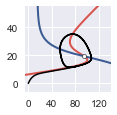

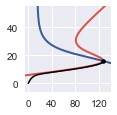

In [4]:
class Parms_H3_Chk1_CellCycle_simple(Parms_CellCycle):
    __beta    = 0.9
    __Ki_H3  = 47

    _parms_str = Parms_CellCycle._parms_str + ['beta', 'Ki_H3']
    _def_parms = Parms_CellCycle._def_parms + [__beta, __Ki_H3]
    _parms_idx = dict(zip(_parms_str, range(len(_parms_str))))


class H3_Chk1_CellCycle_simple(CellCycle):
    _i_Chk1_act = 2
    _i_H3       = 3
    _ylen       = 4
       
    def _Chk1star_act(self, y, parms_list):
        Chk1_act, H3 = y[self._i_Chk1_act], y[self._i_H3]
        Ki_H3 = self.parms.__class__.getval('Ki_H3', parms_list)
        return Chk1_act / (1 + H3 / Ki_H3)
        
    def _k_Cdc25(self, y, parms_list):        
        Chk1star_act = self._Chk1star_act(y, parms_list)
        return super()._k_Cdc25(y, parms_list) * (1 - Chk1star_act)
    
    def _k_Wee1(self, y, parms_list):
        Chk1star_act = self._Chk1star_act(y, parms_list)
        beta = self.parms.__class__.getval('beta', parms_list)
        return super()._k_Wee1(y, parms_list) * (1 + beta*Chk1star_act)

    def _model(self, t, y, parms_list):
        ## Variables
        Cdk1_act, Cdk1_inact, Chk1_act, H3 = y[self._i_Cdk1_act], y[self._i_Cdk1_inact], y[self._i_Chk1_act], y[self._i_H3]

        d_Cdk1_act, d_Cdk1_inact = super()._model(t, y, parms_list)
        d_Chk1_act = 0
        d_H3 = 0
        
        return [d_Cdk1_act, d_Cdk1_inact, d_Chk1_act, d_H3]

    
    @classmethod
    def test_nullclines(cls):
        def _plot(y0, t_end, nc = 11, stable = False, figsize = (1.6, 1.5)):
            beta = 0.9
            
            plt.figure(figsize = figsize)
            plt.subplots_adjust(left = 0.21, right = 0.95, bottom = 0.18, top = 0.97)
                
            m = cls(Parms_H3_Chk1_CellCycle_simple(nc = 13, beta = beta))
            x1, y1, x2, y2 = m.nullclines(Cdk1_range = (0, 0.12), y0 = y0)            
            
            f = 1000
            
            i = np.argmin(abs(y1 - y2))
            plt.plot(f * y1, f * x1, color = red, linewidth = 2)
            plt.plot(f * y2, f * x2, color = blue, linewidth = 2)
            markerfacecolor = "k" if stable else 'w'
            plt.plot(f * y1[i], f * x1[i], "o", markersize = 4, color = "k", markerfacecolor = markerfacecolor, markeredgewidth = 0.5)

            plt.xticks([0, 40, 80, 120], fontsize = 10)
            plt.yticks([0, 20, 40], fontsize = 10)
            plt.ylim((None, 55))
            plt.xlim((-5, 140))
    
            t, y = m.simulate(y0, t_end = t_end, dt = 0.01)
            x3, y3 = y[:, cls._i_Cdk1_act], y[:, cls._i_Cdk1_act] + y[:, cls._i_Cdk1_inact]
            plt.plot(f * y3, f * x3, "k", linewidth = 1.5)
        
        
        _plot([0, 0, 0.14, 0], t_end = 51, stable = False)  ## WT NC13
#         plt.savefig("../figs/H3-Chk1_cell_cycle_model/Simple/Vergassola_parms_Nullclines_Chk1_low.pdf") 

        _plot([0, 0, 0.25, 0], t_end = 100, stable = True)  ## 80% H3 depletion equivalent
#         plt.savefig("../figs/H3-Chk1_cell_cycle_model/Simple/Vergassola_parms_Nullclines_Chk1_high.pdf")  

        plt.show()
    

H3_Chk1_CellCycle_simple.test_nullclines()

grp_NC11 10.0
grp_NC12 10.9
grp_NC13 13.4
NC11 12.7


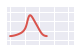

NC12 14.1


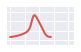

NC13 21.2


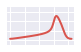

slbp_RNAi_NC13 34.4
slbp_RNAi_NC13_30 160.2
H3_tail_NC12 13.5
H3_tail_NC13 19.4
H3T11A_tail_NC13 20.7
H3T11A_het_NC13 24.1


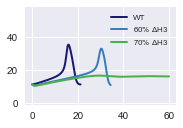

In [5]:
class Parms_H3_mutant_Chk1_CellCycle_simple(Parms_H3_Chk1_CellCycle_simple):
    __Ki_H3T11A = 159
    
    _parms_str = Parms_H3_Chk1_CellCycle_simple._parms_str + ['Ki_H3T11A']
    _def_parms = Parms_H3_Chk1_CellCycle_simple._def_parms + [__Ki_H3T11A]
    _parms_idx = dict(zip(_parms_str, range(len(_parms_str))))


class H3_mutant_Chk1_CellCycle_simple(H3_Chk1_CellCycle_simple):
    _i_H3T11A = 4
    _ylen     = 5
    
    def _Chk1star_act(self, y, parms_list):
        Chk1_act, H3, H3T11A = y[self._i_Chk1_act], y[self._i_H3], y[self._i_H3T11A]
        Ki_H3, Ki_H3T11A = self.parms.__class__.slice_parms(['Ki_H3', 'Ki_H3T11A'], parms_list)
        return Chk1_act * (1 / (1 + H3 / Ki_H3 + H3T11A / Ki_H3T11A))

    def _model(self, t, y, parms_list):
        ## Variables
        Cdk1_act, Cdk1_inact, Chk1_act, H3, H3T11A = y[self._i_Cdk1_act], y[self._i_Cdk1_inact], y[self._i_Chk1_act], y[self._i_H3], y[self._i_H3T11A]

        d_Cdk1_act, d_Cdk1_inact, d_Chk1_act, d_H3 = super()._model(t, y, parms_list)
        d_H3T11A = 0
        
        return [d_Cdk1_act, d_Cdk1_inact, d_Chk1_act, d_H3, d_H3T11A]

    
    @classmethod
    def cell_cycle_H3(cls):
        beta = 0.9
        Chk1 = 0.33
        
        def _analyze(y0, nc, label = None, plot = False):
            m = cls(Parms_H3_mutant_Chk1_CellCycle_simple(nc = nc, beta = beta))
            t, y = m.simulate(y0 = y0, t_end = 160, dt = 0.1, print_parms = False)
            t, y = m.crop_one_cycle(t, y)
            print(label, len(y)/10)
            
            if plot:
                plt.figure(figsize = (1.2, 0.7))

                f = 1000
                lw = 2

                plt.plot(t - t[0], f * y[:, 0] , red, lw = lw)
               
                plt.xlim((-1, 22))
                plt.ylim((5, 45))
                plt.yticks((10, 20, 30, 40), ['', '', '', ''], fontsize = 10)
                plt.xticks([0, 5, 10, 15, 20], ['', '', '', '', ''], fontsize = 10)

#                 plt.savefig("../figs/H3-Chk1_cell_cycle_model/Simple/cell_cycle_H3_manipulation/Vergassola_parms_%s.pdf" % label)

                plt.show()

    
        H3_NC11, H3_NC12, H3_NC13 = 87, 73, 52
        
        ## Chk1 null
        _analyze([0, 0, 0, H3_NC11, 0], 11, "grp_NC11")  ## grp NC11
        _analyze([0, 0, 0, H3_NC12, 0], 12, "grp_NC12")  ## grp NC12
        _analyze([0, 0, 0, H3_NC13, 0], 13, "grp_NC13")  ## grp NC13
        
        ## WT
        _analyze([0, 0, Chk1, H3_NC11, 0], 11, "NC11", plot = True)  ## WT NC11
        _analyze([0, 0, Chk1, H3_NC12, 0], 12, "NC12", plot = True)  ## WT NC12
        _analyze([0, 0, Chk1, H3_NC13, 0], 13, "NC13", plot = True)  ## WT NC13                
        
        ## Manipulation
        _analyze([0, 0, Chk1, H3_NC13*0.4, 0], 13, "slbp_RNAi_NC13")     ## slbp RNAi NC13    
        _analyze([0, 0, Chk1, H3_NC13*0.3, 0], 13, "slbp_RNAi_NC13_30")  ## slbp RNAi NC13    
        
        _analyze([0, 0, Chk1, H3_NC12*1.31, 0], 12, "H3_tail_NC12")            ## H3 tail overexpression NC13
        _analyze([0, 0, Chk1, H3_NC13*1.31, 0], 13, "H3_tail_NC13")            ## H3 tail overexpression NC13
        _analyze([0, 0, Chk1, H3_NC13, H3_NC13*0.31], 13, "H3T11A_tail_NC13")  ## H3 tail overexpression NC13

        f = 0.6
        _analyze([0, 0, Chk1, H3_NC13*f, H3_NC13*(1-f)], 13, "H3T11A_het_NC13")  ## H3T11A replacement
        
    
    @classmethod
    def slbp_RNAi(cls):
        beta = 0.9
        Chk1 = 0.33
        
        def _analyze(y0, nc, xlim = 120, label = None, col = "k"):
            m = cls(Parms_H3_mutant_Chk1_CellCycle_simple(nc = nc, beta = beta))
            _t, _y = m.simulate(y0 = y0, t_end = 120, dt = 0.1, print_parms = False)
            t, y = m.crop_one_cycle(_t, _y)
            xi = int(xlim*10)+1
            plt.plot(_t[:xi], _y[:xi, 0]*1000, label = label, linewidth = 2, color = col)
            plt.ylim((-0.01, 60))
        
        H3_NC11, H3_NC12, H3_NC13 = 87, 73, 52
        
        col1 = "midnightblue"
        col2, col3 = sns.color_palette("Set1")[1:3]
        
        plt.figure(figsize = (2.7, 1.8))
        a, i = 1.12953587e-02, 5.98837723e-02
        _analyze([a, i, Chk1, H3_NC13, 0], 13, xlim = 21.2, label = "WT", col = col1)       ## slbp RNAi NC13         
        _analyze([a, i, Chk1, H3_NC13*0.4, 0], 13, xlim = 34.4, label = "$\mathregular{60\% \ \Delta H3}$", col = col2)       ## slbp RNAi NC13 
        _analyze([a, i, Chk1, H3_NC13*0.3, 0], 13, xlim = 60, label = "$\mathregular{70\% \ \Delta H3}$", col = col3)   
               
        plt.legend(frameon = False, fontsize = 8)
        plt.yticks([0, 20, 40])
        plt.ylim((-1, 58))
        
#         plt.savefig("../figs/H3-Chk1_cell_cycle_model/Simple/cell_cycle_H3_manipulation/Vergassola_parms_slbp_RNAi_NC13_2.pdf")
    
H3_mutant_Chk1_CellCycle_simple.cell_cycle_H3()
H3_mutant_Chk1_CellCycle_simple.slbp_RNAi()